In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from proj1_helpers import *
import pandas as pd
%load_ext autoreload
%autoreload 2

# Load the training data into feature matrix, class labels, and event ids:

In [2]:
DATA_TRAIN_PATH = "../data/train.csv"
labels, data, ids = load_csv_data(DATA_TRAIN_PATH)

In [3]:
feature_names = ["DER_mass_MMC","DER_mass_transverse_met_lep","DER_mass_vis","DER_pt_h","DER_deltaeta_jet_jet","DER_mass_jet_jet","DER_prodeta_jet_jet","DER_deltar_tau_lep","DER_pt_tot","DER_sum_pt","DER_pt_ratio_lep_tau","DER_met_phi_centrality","DER_lep_eta_centrality","PRI_tau_pt","PRI_tau_eta","PRI_tau_phi","PRI_lep_pt","PRI_lep_eta","PRI_lep_phi","PRI_met","PRI_met_phi","PRI_met_sumet","PRI_jet_num","PRI_jet_leading_pt","PRI_jet_leading_eta","PRI_jet_leading_phi","PRI_jet_subleading_pt","PRI_jet_subleading_eta","PRI_jet_subleading_phi","PRI_jet_all_pt"]
categorical_variable = feature_names.index("PRI_jet_num")

# Exploratory data analysis

How many events are there compared to non-events?

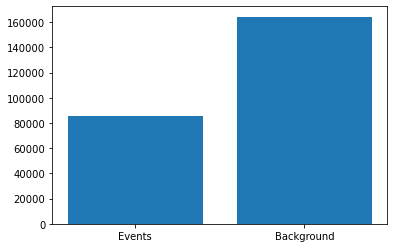

In [4]:
events = np.count_nonzero(labels == 1)
nonevents = len(labels) - events
plt.bar(["Events", "Background"], [events, nonevents])
plt.show()

There's roughly twice as many background noise as there are events in the training set. We have to be careful of this fact when using cross-validation.

How is it distributed with regards to PRI_jet_num?

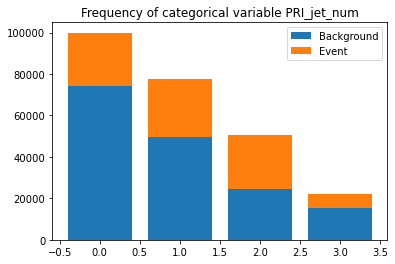

In [6]:
events = data[np.where(labels == 1)]
nonevents = data[np.where(labels != 1)]

unique, counts = np.unique(nonevents[:,categorical_variable], return_counts=True)
plt.bar(unique, counts)
_, counts2 = np.unique(events[:,categorical_variable], return_counts=True)
plt.bar(unique, counts2, bottom=counts)
plt.legend(["Background", "Event"])
plt.title("Frequency of categorical variable PRI_jet_num")
plt.show()

## Which features should be merged together?

In [4]:
def generate_correlation_set(tX, t):
    corr_set = set()
    df = pd.DataFrame(tX)
    corr = df.corr()
    for i, row in enumerate(corr):
        for j, col in enumerate(corr):
            if i != j and corr.loc[i,j] > t:
                corr_set.add((i,j))
                
    return _pairs_to_groups(corr_set)

def _pairs_to_groups(pairs):
    groups = set()
    edges = _create_dict_from_tuples(pairs)
    vertices = edges.keys()
    done = set()

    for vertex in vertices:
        if vertex not in done:
            groups.add(frozenset(_depth_first_search(vertex, edges, done)))

    return groups

def _depth_first_search(vertex, edges, done):
    group = {vertex}
    done.add(vertex)

    for v_adj in edges[vertex]:
        if v_adj not in done:
            group.update(_depth_first_search(v_adj, edges, done))

    return group

def _create_dict_from_tuples(tuples):
    dict_ = dict()

    for x, y in tuples:
        if x not in dict_:
            dict_[x] = set()
        dict_[x].add(y)

    return dict_

In [18]:
for s in generate_correlation_set(data, 0.96):
    for i in s:
        print(feature_names[i])
    print()

PRI_jet_leading_eta
PRI_jet_leading_phi
PRI_jet_leading_pt

DER_deltaeta_jet_jet
DER_prodeta_jet_jet
PRI_jet_subleading_pt
PRI_jet_subleading_eta
DER_lep_eta_centrality
PRI_jet_subleading_phi

DER_sum_pt
PRI_jet_all_pt



# Data processing

There's a few different approaches we could take for feature processing:
1. Divide the dataset into four, one for each categorical variable.
2. Split the categorical variable into multiple boolean columns, one for each type it could be.

Regardless, the data should be properly normalized beforehand (made exception for the categorical variable), as not normalizing it leads to overflows when running any sort of regression

In [5]:
mean, std = np.mean(data, axis=0), np.std(data, axis=0)

Logistic regression expects labels to be of the form {0, 1}.  
Since the labels given to us are instead of the form {-1, 1}, we also need to normalize them to use logistic regression.
Other forms of regression work well no matter the form of the labels, so we stick with {0, 1}

In [6]:
def normalize_labels(labels):
    return np.round((labels + 1) / 2)

## Compare methods & Optimize hyperparameters
Let's see which of the regression methods performs best using k-fold cross validation

In [38]:
from validation import *
from implementations import *

y = normalize_labels(labels)
tx = data

In [8]:
k = 6
indices = build_k_indices(len(y), k)
cross_validation(y, tx, indices,)

TypeError: cross_validation() missing 1 required positional argument: 'train_function'

In [9]:
def cartesian_product(x, y):
    return np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])

In [39]:
max_iters = 30
initial_w = np.zeros(tx.shape[1])
gammas = np.logspace(-20, -10, 10)
lambdas = np.logspace(-10, 1, 10)
hyperparams = cartesian_product(gammas, lambdas)

def gradient_descent(train_function):
    return lambda y, tx, param: train_function(y, tx, initial_w, max_iters, param)

def gradient_descent_multi(train_function):
    return lambda y, tx, param: train_function(y, tx, initial_w, max_iters, *param)

In [42]:
gammas = [ 1*(10**-i) for i in range(1,20)]
gammas

[0.1]

In [43]:
nested_cross_validation(y, tx, indices, gammas, gradient_descent(least_squares_GD)),

[4.80003072e-06]
0
Best hyperparam for iteration 0: 0.1, acc: 4.800030720196609e-06
[0.]
0
Best hyperparam for iteration 1: 0.1, acc: 0.0
[4.80003072e-06]
0
Best hyperparam for iteration 2: 0.1, acc: 4.800030720196609e-06
[0.]
0
Best hyperparam for iteration 3: 0.1, acc: 0.0
[0.]
0
Best hyperparam for iteration 4: 0.1, acc: 0.0


KeyboardInterrupt: 

In [11]:
k = 6
indices = build_k_indices(len(y), k)
method_results = {
    'Least squares GD' : nested_cross_validation(y, tx, indices, gammas, gradient_descent(least_squares_GD)),
    'Least squares SGD' : nested_cross_validation(y, tx, indices, gammas, gradient_descent(least_squares_SGD)),
    'Explicit least squares' : cross_validation(y, tx, indices, least_squares),
    'Ridge regression' : nested_cross_validation(y, tx, indices, lambdas, ridge_regression),
    'Logistic regression GD' : nested_cross_validation(y, tx, indices, gammas, gradient_descent(logistic_reg_GD)),
    #'Regularized log. regression GD' : nested_cross_validation(y, tx, indices, hyperparams, gradient_descent_multi(penalized_logistic_reg_GD))
}

/home/sander/.local/share/virtualenvs/python-bwDr9nQb/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Best hyperparam for iteration 0: 2.1544346900318778e-17
Best hyperparam for iteration 1: 2.1544346900318778e-17


KeyboardInterrupt: 

In [ ]:
results = np.array(list(method_results.values()))
plt.barh(list(method_results.keys()), results[:, 0], xerr=results[:, 1])
plt.xlim(0, 1)
plt.xlabel("Correct prediction ratio")
plt.title("Results of full regression (all variables)")
plt.savefig("../figs/regresults.pdf")
plt.show()

In [ ]:
def feature_augmentation(tx, degree):
    powers = [np.power(tx, deg) for deg in range(1,degree+1)]
    return np.concatenate(powers, axis=1)

In [17]:
lambda_ = 2e-8
k = 6
indices = build_k_indices(len(y), k)
method = lambda y, tx: ridge_regression(y, tx, lambda_)

print("Degree 1:", cross_validation(y, tx, indices, method))
print("Degree 2:", cross_validation(y, feature_augmentation(tx, 2), indices, method))

Degree 1: [0.7435519889910868, 0.001162133221486503]
Degree 2: [0.700479994585618, 0.0006361664576700189]


# Create a (simple) submission

In [105]:
DATA_TEST_PATH = "../data/test.csv"
_, tx_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [23]:
OUTPUT_PATH  = "../data/predictions.csv"

weights, _ = ridge_regression(labels, tx, lambda_)
labels_test = predict_labels(weights, tx_test)
create_csv_submission(ids_test, labels_test, OUTPUT_PATH)

NameError: name 'tx_test' is not defined

## Separating data by group

In [26]:
useless_features = {
    0: ["DER_deltaeta_jet_jet", "DER_mass_jet_jet", "DER_prodeta_jet_jet", "DER_lep_eta_centrality",
        "PRI_jet_leading_pt", "PRI_jet_leading_eta", "PRI_jet_leading_phi",
        "PRI_jet_subleading_pt", "PRI_jet_subleading_eta", "PRI_jet_subleading_phi","PRI_jet_all_pt"
       ],
    1: ["DER_deltaeta_jet_jet", "DER_mass_jet_jet", "DER_prodeta_jet_jet", "DER_lep_eta_centrality",
        "PRI_jet_subleading_pt", "PRI_jet_subleading_eta", "PRI_jet_subleading_phi"
       ],
    2: [],
    3: []
}


def group_by_jet_num(y, tx, jet_num):
    indices = np.where(tx[:, categorical_variable] == jet_num)
    useless = useless_features[jet_num] + ["PRI_jet_num"]
    useless_indices = [feature_names.index(feat) for feat in useless]
    tx_ = np.delete(tx, useless_indices, axis=1)
    return [y[indices], tx_[indices]]


def group_data(y, tx):
    data_grouped = [
        group_by_jet_num(y, tx, jet_num)
        for jet_num in range(4)
    ]
    # Create one single group for jet_nums 2 and 3
    data_grouped[2][0] = np.concatenate([data_grouped[2][0], data_grouped[3][0]])
    data_grouped[2][1] = np.concatenate([data_grouped[2][1], data_grouped[3][1]])
    data_grouped.pop(3)
    return data_grouped

data_grouped = group_data(y, data)

In [37]:
def polynomial_expansion(tx, degree):
    powers = [np.power(tx, i) for i in range(2, degree)]
    return [tx] + powers


def feature_expansion(tx):
    return np.concatenate(polynomial_expansion(tx, 3) + [np.sin(tx), np.log(np.abs(tx) + 1e-10)],axis=1)


avg_acc = np.zeros(2)
for y, tx in data_grouped:
    indices = build_k_indices(len(y), 5)
    tx = feature_expansion(tx)
    avg_acc += cross_validation(y, tx, indices, least_squares)
avg_acc / len(data_grouped)

array([0.7940069, 0.0022092])

In [23]:
from proj1_helpers import *
DATA_TRAIN_PATH = "../data/train.csv"
y, tx, ids = load_csv_data(DATA_TRAIN_PATH)

def calculate_weights(y, tx):     
    tx = feature_expansion(tx)
    weights, _ = least_squares(y, tx)
    return weights

w_by_group = [calculate_weights(y, tx) for y, tx in group_data(y, tx)]

In [25]:
OUTPUT_PATH = 'predictions.csv'

def predict_labels_grouped(w_by_group, ids, data):
    """Generates class predictions given weights, and a test data matrix"""
    data_grouped = group_data(ids, data) # List[ (Id, tX)]
    y_pred = np.array([])
    ids_pred = np.array([])
    for group, w in zip(data_grouped, w_by_group):
        ids, tx = group
        tx = feature_expansion(tx)
        y_pred = np.concatenate([y_pred, tx @ w])
        ids_pred = np.concatenate([ids_pred, ids])
    y_pred[y_pred > 0] = 1
    y_pred[y_pred <= 0] = -1
    return y_pred, ids_pred

y_pred, ids_pred = predict_labels_grouped(w_by_group, ids_test, tX_test)
pred_arr = np.column_stack((ids_pred, y_pred))
sorted_pred = pred_arr[pred_arr[:,0].argsort()]

create_csv_submission(sorted_pred[:, 0], sorted_pred[:, 1], OUTPUT_PATH)